In [73]:
import pandas as pd
import numpy as np
import re
import os

from kiwipiepy import Kiwi
from kiwipiepy.utils import Stopwords

In [49]:
# 폰트 경로 지정(한글깨짐 이슈 해결)
FONT_PATH = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf' # 코랩 환경 폰트
FONT_PATH = 'C:/Windows/Fonts/malgun.ttf' # 로컬 환경 폰트

### 1. 데이터 불러오기

In [29]:
# csv데이터 불러오기
content_df = pd.read_csv('text_data.csv')
content_df

# 제목과 본문 + 댓글 합쳐서 데이터프레임 만들기
content_df['Content'] = content_df['title'].fillna('') + ' ' + content_df['content'].fillna('') + ' ' + content_df['comment'].fillna('') # NaN값을 빈 문자열로 대체하여 병합
content_df = pd.DataFrame(content_df['Content'])
content_df

,Content
0,화식/동결이랑 사료 섞어서 줘도 가능한가요? 다들 보통 동결건조 사료 언제쯤 시작하...
1,내돈내산 강아지 화식 리뷰 물만 부으면 완성되는 화식이 있길래 사봤어요 들어간 재료...
2,포옹 생식이나 화식 어떤가요?? 저희애들이 다양한 주식용 화식/생식 먹어봤는데 포옹...
3,화식(습식사료) 추천해주세요~!! 최근 설채현쌤이나 유튭 트레이너분들 영상을 보니 ...
4,강아지화식 먹이시는분 계시나요? 어제 애견카페 갔었는데 거기서 만난분들이\n강아지화...
...,...
2087,씽크라이크펫 화식 구해요ㅠㅠㅠ 이전글 다음글 목록\n▶ 통합 자유게시판\n씽크라이크...
2088,듀x 화식 급여 후 장염 14개월 말티푸 사료투정이 심해서\n사료 유목민으로 살다가...
2089,화식 급여 후 배변.. 이전글 다음글 목록\n▶ 통합 자유게시판\n화식 급여 후 배...
2090,사료에 섞어줄화식 사료만 주면 잘 안먹어요.\n제탓이겠죠ㅡㅡ\n디어니스트키친 파테 ...


### 2. 데이터 전처리

#### 2.1 특수 기호 및 문자 제거

In [31]:
def clean_text(text):
    text = re.sub(r'[^\w\s]', ' ', text) # 특수 문자 제거
    text = re.sub(r'\s+', ' ', text).strip()  # 다중 공백 제거
    return text

content_df['Content'] = content_df['Content'].apply(clean_text)

#### 2.2 문서 분리(데이터에 따라 실행)

In [33]:
#본문, 댓글들을 각각 하나의 문서로 분리
text_list = []

for i, row in content_df.iterrows():
    texts = row['Content'].split('\n') # 줄 띄움을 기준으로 분리
    
    for text in texts:
        text = clean_text(text) # 2.1 특수 기호 및 문자 제거 함수 호출

        if len(text) >= 10: # 길이가 10이상인 문자열만 추출
            if re.match(r'^\d+(\s\d+)*$', text):  # 숫자로만 이루어진 문자열 제거
                continue
            else:
                text_list.append(text)

### 3. 형태소 분석

- 사용자 정의 형태소와 제거할 형태소 정의

In [57]:
custom_list = ['레이앤이본','도그델리','룰루키친','포옹','아르밀','디어니스트키친','동결건조','그레인프리','다이어트','공복토','노령견','노견','고단백','고지방','단백질'
               ,'묽은변','음수량','비추천','지위픽']

stop_list = ['화식','사료','글쓰기', '복사','이웃','추가','본문','기타','기능','공유','신고','포스팅','설정','해상도','음소거','재생','음소거','댓글','덧글','안녕'
            '오늘','경우','정도','다음','페이징','도움말','자막','영상','하루','가지','배경','실시간','화질','화면','오류','글자','취소','글쓰기','추천','감사'
            '부탁','체험','이동','시간','입력','목록','엄마','처음','등록','관심','검색','시간','구독','게시', '감사', '댓글']  

In [59]:
kiwi = Kiwi(model_type='sbg')

# 사용자 정의 함수(형태소) 생성
for word in custom_list:
    kiwi.add_user_word(word)

# kiwi 모델 내장 불용어 정의
stopwords = Stopwords()

# 사용자 지정 불용어를 기존 불용어 목록에 추가
for stop in stop_list:
    stopwords.add(stop)

-  표준화 사전: 같은 단어를 한 단어로 정의하는 딕셔너리 생성

In [60]:
standardization_dict = {'전자레인지':'전자렌지','렌지':'전자렌지','노견':'노령견','알레르기':'알러지','채소':'야채'}  

In [61]:
word_total=[] # 문서별 형태소 분석 데이터를 저장할 리스트
token_count = [] # 형태소별 빈도를 저장할 리스트

noun_tag=['NNP','NNG','NNB'] # 명사 태그
verb_adj_tag = ['VV', 'VA']  # 동사, 형용사 태그

for row in text_list:
    tokens = kiwi.tokenize(row, stopwords=stopwords) # 형태소 분석, 불용어 제거

    token_list = []
    for token in tokens: # 형태소 추출

        # 형태소가 명사(NN)일 경우
        if (token.tag in noun_tag) and (len(token.form) >=2) : # 토큰 길이가 2 이상인 경우만 처리
            
            if re.match(r'^-?\d+(\.\d+)?$', token.form) : # 숫자로만 이루어져 있는 문자열 제거
                continue
            
            else: # 표준화 사전에 존재하면 표준화된 단어로 대체
              if token.form in standardization_dict.keys():
                standardized_form  = standardization_dict[token.form]
              else:
                standardized_form  = token.form
              
              # 표준화된 형태소 추가
              token_list.append(standardized_form)
              # 형태소 빈도 기록
              token_count.append([standardized_form, 1])

        # 동사(VV) 또는 형용사(VA)일 경우
        elif (token.tag in verb_adj_tag) and (len(token.form) >=2): # 토큰 길이가 2 이상인 경우만 처리
             
             # 형태소의 원형(lemma)을 추출
            lemma = kiwi.analyze(token.form)[0][0][0].lemma

            if lemma in standardization_dict.keys(): # 표준화 사전에 존재하면 표준화된 단어로 대체
              standardized_form  = standardization_dict[lemma]
            else:
              standardized_form  = lemma
            
            # 표준화된 형태소 추가
            token_list.append(standardized_form)
            # 형태소 빈도 기록
            token_count.append([standardized_form, 1])

    # 형태소 리스트를 문자열로 조합하여 전체 키워드 리스트에 추가
    word_total.append(' '.join(token_list))

In [62]:
word_df = pd.DataFrame(token_count, columns=['형태소','카운트'])

word_df = word_df.groupby(['형태소'])['카운트'].sum().reset_index() # 형태소 기준 카운트 총합
word_df = word_df.sort_values(by='카운트', ascending=False) # 빈도수 기준으로 내림차순 정렬
word_df = word_df[word_df['카운트']>=15] # 카운트가 15이상인 행만 추출

# 인덱스 재설정
word_df=word_df.reset_index()
word_df=pd.DataFrame(word_df.iloc[:,1:])

### 3. 빈도분석

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import warnings
import matplotlib.colors as mcolors
from matplotlib import font_manager, rc

#### 3.1 워드클라우드 시각화

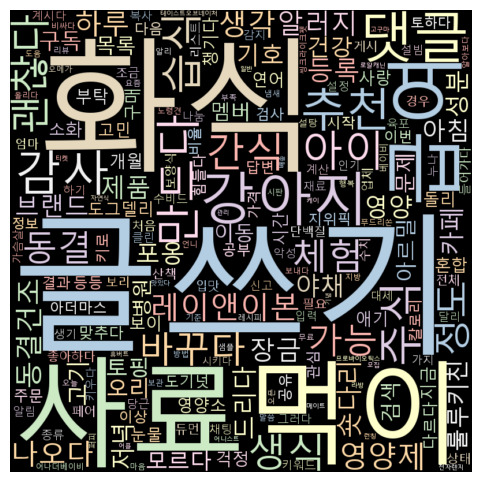

In [64]:
# 단어 빈도 데이터를 사전 형태로 변환
word_freq = dict(zip(word_df['형태소'], word_df['카운트']))

# WordCloud 생성
wc = WordCloud(
    font_path=FONT_PATH,            # 한글 지원 폰트 경로 지정
    background_color="black",       # 배경색 지정 (검정색)
    colormap='Pastel1',             # 색상 조합 지정
    width=800,                      # 워드클라우드 이미지의 너비
    height=800                      # 워드클라우드 이미지의 높이
).generate_from_frequencies(word_freq)  # 단어 빈도 데이터를 기반으로 워드클라우드 생성

# 생성된 워드클라우드 이미지 출력
plt.figure(figsize=(6, 6))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')  # 축 숨기기
plt.show()

#### 3.2 상위 빈도수 형태소 시각화

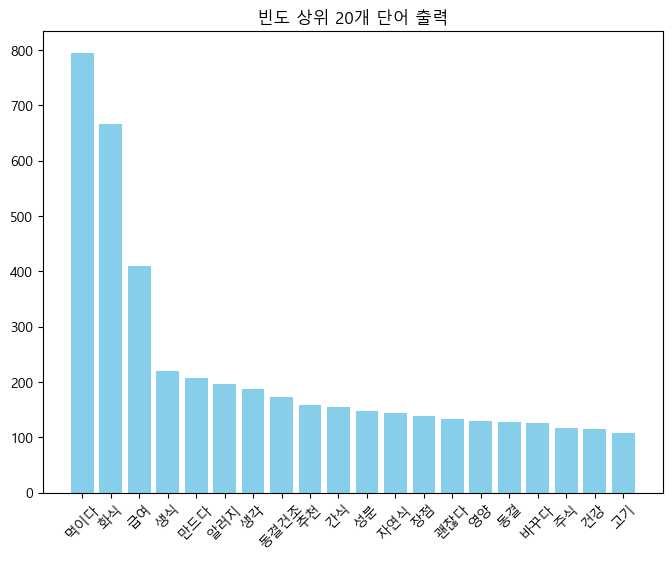

In [104]:
warnings.filterwarnings("ignore")

FONT_NAME= font_manager.FontProperties(fname=FONT_PATH).get_name()
plt.rc('font', family=FONT_NAME)

word_df20 = word_df.head(20) # 상위 20개만 출력

plt.figure(figsize = (8, 6))
plt.title('빈도 상위 20개 단어 출력')
plt.bar(word_df20['형태소'], word_df20['카운트'],color='skyblue')
plt.xticks(rotation=45)
plt.show()

### 4. LDA 토픽 모델링

In [65]:
from gensim import corpora,models # 단어 빈도수 계산 패키지
import gensim # LDA 모델 활용 목적
import pyLDAvis.gensim_models # LDA 시각화용 패키지
from collections import Counter # 단어 등장 횟수 카운트
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary

#### 4.1 토픽모델링 최적화

In [ ]:
total_df=pd.DataFrame(word_total)

# 입력된 텍스트 데이터를 단어 리스트로 변환
texts = total_df.iloc[:,0].apply(lambda x: x.split()).tolist()

 # 단어 인코딩 및 빈도수 계산
dictionary = Dictionary(texts) # 각 단어에 고유 인덱스 부여
corpus = [dictionary.doc2bow(word) for word in texts] # 단어의 빈도를 계산해 BOW(Bag of Words) 형식으로 변환

- Perpelxity 혼란도

<function matplotlib.pyplot.show(close=None, block=None)>

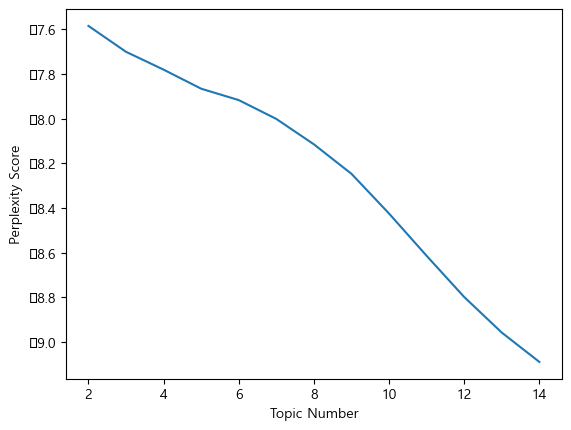

In [84]:
# 토픽 개수별 Perplexiity 혼란도 평가 (값이 낮을 수록 예측 성능이 좋음)
perplexity_values=[]

for i in range(2,15):
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = i, id2word = dictionary)
    perplexity_values.append(ldamodel.log_perplexity(corpus))

# 시각화
x=range(2,15)
plt.plot(x,perplexity_values)
plt.xlabel("Topic Number")
plt.ylabel("Perplexity Score")
plt.show

- Coherence 일관도

<function matplotlib.pyplot.show(close=None, block=None)>

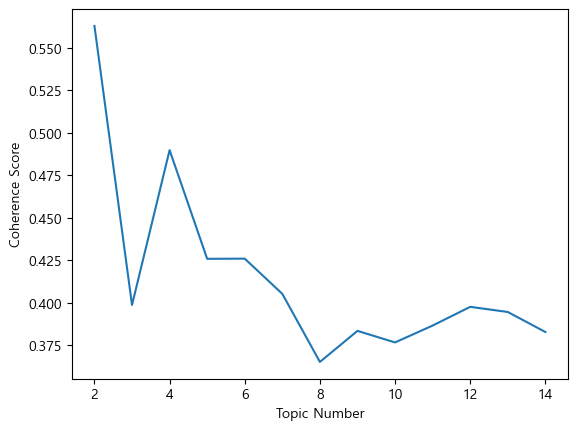

In [85]:
# 토픽 개수별 Coherence 일관도 계산 (값이 높을수록 해석 가능하고 일관성)
coherence_values=[]

for i in range(2,15):
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = i, id2word = dictionary)
    coherence_model_lda=CoherenceModel(model=ldamodel, texts=texts, dictionary=dictionary, topn=10)
    coherence_lda=coherence_model_lda.get_coherence()
    coherence_values.append(coherence_lda)

#시각화
x=range(2,15)
plt.plot(x,coherence_values)
plt.xlabel("Topic Number")
plt.ylabel("Coherence Score")
plt.show

- passes: 딥러닝에서 Epoch와 같은 개념으로, 전체 corpus로 모델 학습 횟수 결정

In [86]:
passes_values = [10, 15, 20, 25, 30, 35]

coherence_scores = []
perplexity_scores = []

# 각 passes 값에 대해 모델 학습 및 평가
for passes in passes_values:
    # LDA 모델 학습
    lda_model = gensim.models.LdaModel(corpus, 
                                       num_topics=6, 
                                       id2word=dictionary, 
                                       passes=passes)
    
    # Coherence Score 계산
    coherence_model = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    coherence_scores.append(coherence_score)
    
    # Perplexity 계산
    perplexity_score = lda_model.log_perplexity(corpus)
    perplexity_scores.append(perplexity_score)

print(coherence_scores) #값이 높을수록 좋음
print(perplexity_scores) #값이 낮을수록 좋음

[0.46936155550487973, 0.4992774935028523, 0.4739868570913726, 0.4673526087771916, 0.4619150827076903, 0.4287902275791102]
[-7.638614626657586, -7.609721909355777, -7.594159742215026, -7.5981989277123745, -7.586814965943255, -7.57937401808977]


#### 4.2 LDA 함수생성

In [78]:
# LDA 모델 학습 함수
def lda_modeling(word_total, NUM_TOPICS, PASSES):
    total_df=pd.DataFrame(word_total)

     # 입력된 텍스트 데이터를 단어 리스트로 변환
    texts = total_df.iloc[:,0].apply(lambda x: x.split()).tolist()

    # 단어 인코딩 및 빈도수 계산
    dictionary = Dictionary(texts) # 각 단어에 고유 인덱스 부여
    corpus = [dictionary.doc2bow(word) for word in texts] # 단어의 빈도를 계산해 BOW(Bag of Words) 형식으로 변환
    
    # LDA 모델 학습
    model = gensim.models.ldamodel.LdaModel(
        corpus=corpus,             # BOW 형식의 말뭉치 데이터
        num_topics=NUM_TOPICS,     # 추출할 토픽 개수
        id2word=dictionary,        # 단어 인코딩 정보
        passes=PASSES              # 데이터 반복 학습 횟수
    )
    
    return model, corpus, dictionary 


# 토픽별 단어 비율 출력 함수
def print_topic(topics):
    topic_values = []  # 토픽별 단어 비율을 저장할 리스트
    
    for topic in topics:
        topic_value = topic[1] # 토픽 내 단어의 비율 값 추출
        topic_values.append(topic_value)

    # 토픽 번호와 단어 비율 데이터프레임 생성
    topic_prop = pd.DataFrame({"topic_num" :range(1, NUM_TOPICS + 1), "word_prop": topic_values})
    
    display(topic_prop)  # 데이터프레임 출력 (Jupyter 환경에서 사용)

# lda 결과 시각화 함수
def lda_visualize(model, corpus, dictionary):
    # Jupyter Notebook에서 시각화 활성화
    pyLDAvis.enable_notebook()

    result_visualized = pyLDAvis.gensim_models.prepare(model, corpus, dictionary)

    # 시각화 결과 저장
    RESULT_FILE = 'LDA_result' + '.html'
    pyLDAvis.save_html(result_visualized, RESULT_FILE) # 시각화 결과를 HTML 파일로 저장

    return result_visualized

In [69]:
total_df=pd.DataFrame(word_total)

NUM_TOPICS = 4 # 토픽 개수
PASSES = 15 # 학습 횟수

model, corpus, dictionary = lda_modeling(word_total, NUM_TOPICS, PASSES) # 모델 학습
NUM_WORDS = 10 

topics = model.print_topics(num_words = NUM_WORDS)
print_topic(topics)

,topic_num,word_prop
0,1,"0.065*""글쓰기"" + 0.056*""화식"" + 0.050*""사료"" + 0.030*..."
1,2,"0.051*""글쓰기"" + 0.032*""먹이"" + 0.031*""화식"" + 0.029*..."
2,3,"0.082*""글쓰기"" + 0.050*""화식"" + 0.036*""먹이"" + 0.014*..."
3,4,"0.088*""화식"" + 0.076*""댓글"" + 0.044*""강아지"" + 0.033*..."


- LDA 토픽 모델링 결과 저장 및 시각화

In [81]:
result_visualized = lda_visualize(model, corpus, dictionary) # LDA 결과 시각화
pyLDAvis.display(result_visualized)

### 5. TF-IDF 연관분석

In [141]:
from sklearn.feature_extraction.text import CountVectorizer
import networkx as nx
from matplotlib import rcParams

- max_feature: 상위 n개의 단어를 추출

In [82]:
max_feature = 15 

<Axes: >

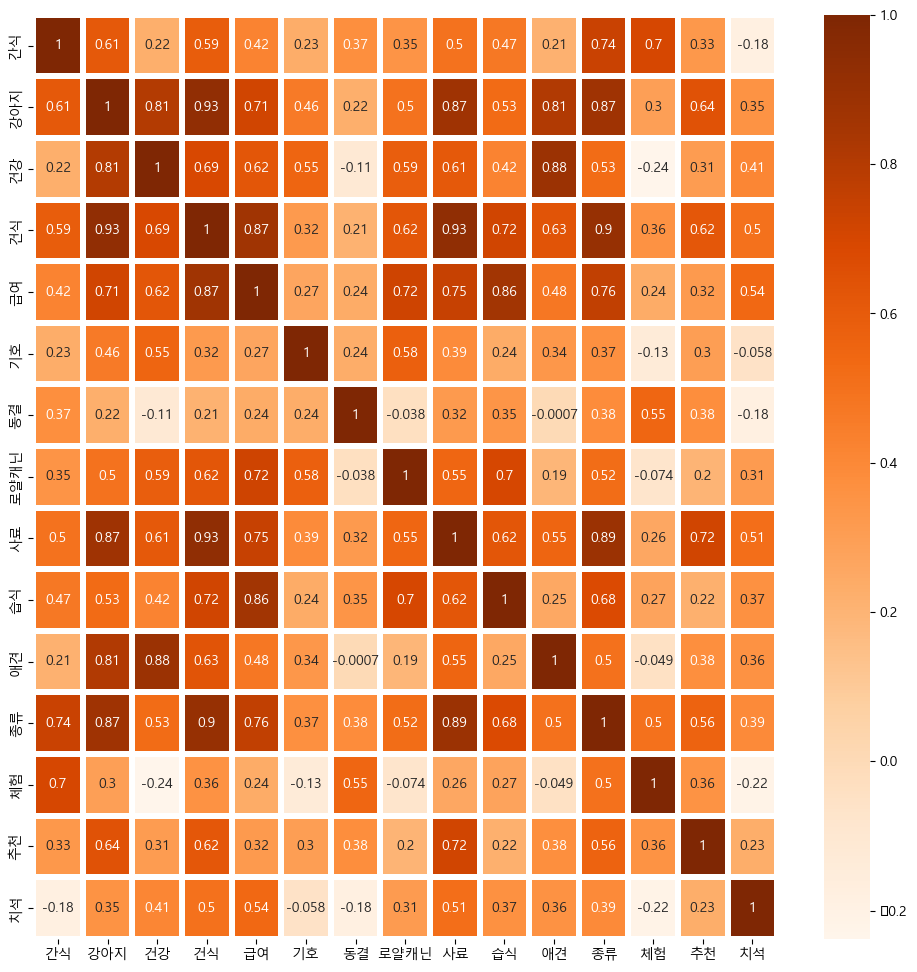

In [145]:
# CountVectorizer 객체 생성: 가장 자주 언급된 단어 추출
countvectorizer = CountVectorizer(max_features = max_feature)

# word_total에서 단어 등장 빈도를 기반으로 DTM(단어-문서 행렬) 생성
dtm = countvectorizer.fit_transform(word_total)

dtm_dense = dtm.todense() # 희소 행렬을 밀집 행렬로 변환
words_name = countvectorizer.get_feature_names_out() # 추출된 단어 목록 가져오기

# 단어 간 상관관계 행렬 계산 (열 기준)
word_corr = np.corrcoef(dtm_dense, rowvar=0)
corr_df = pd.DataFrame(word_corr)

corr_word_list = [] # 단어 간 상관관계를 저장

# 단어-단어 상관관계 추출
for i in range(dtm_dense.shape[1]):
    for j in range(dtm_dense.shape[1]):
    corr_word_list.append((words_name[i],words_name[j], word_corr[i,j]))

# 상관관계가 높은 순으로 정렬
corr_word_sorted = sorted(corr_word_list, key=lambda x: x[2], reverse=True)

heatmap_list=[]

# 상관관계 행렬을 2D 리스트로 변환
li_tem=[]
for i in range(0, max_feature*max_feature, max_feature):  # max_feature 단위로 행을 구분
    li_tem=[]
    
    for j in range(i,i+max_feature): # max_feature 단위로 열을 구분
        li_tem.append(corr_word_list[j][2])
        
    heatmap_list.append(li_tem)    

# 상위 max_feature 개의 단어만 추출
corr_name=[item[1] for item in corr_word_list[:max_feature]]

# DataFrame으로 변환하여 상관행렬을 정리
df_corr = pd.DataFrame(heatmap_list)
df_corr.index = corr_name # 행 이름을 단어로 설정
df_corr.columns = corr_name # 열 이름을 단어로 설정

# Heatmap 시각화
plt.figure(figsize=(12,12))
sns.heatmap(df_corr, cmap='Oranges',annot=True, linewidth=3)

### 6. WordNetwork

- max_feature: 상위 n개의 단어를 추출

In [ ]:
max_feature = 40

In [147]:
# CountVectorizer 객체 생성: 가장 자주 언급된 단어를 추출
countvectorizer = CountVectorizer(max_features=max_feature) 

# word_total에서 단어 등장 빈도를 기반으로 DTM(단어-문서 행렬) 생성
dtm = countvectorizer.fit_transform(word_total)

dtm_dense = dtm.todense() # 희소 행렬을 밀집 행렬로 변환
words_name = countvectorizer.get_feature_names_out() # 단어 목록 가져오기

# 단어 간 상관계수 계산 (열 기준)
word_corr = np.corrcoef(dtm_dense, rowvar=0)
corr_df = pd.DataFrame(word_corr)

# 단어 이름과 상관계수 목록
corr_word_list=[]

# 상관계수를 기반으로 단어 간 관계 추출
for i in range(dtm_dense.shape[1]):
    for j in range(dtm_dense.shape[1]):
      corr_word_list.append((words_name[i],words_name[j], word_corr[i,j]))

# 상관계수에 따라 단어 쌍을 내림차순으로 정렬
corr_word_sorted = sorted(corr_word_list, key=lambda x: x[2], reverse=True)

In [148]:
edgelist=np.dot(dtm_dense.T, dtm_dense)
print(edgelist.shape)
edgelist

(40, 40)


matrix([[  79,  270,   40, ...,   16,   18,   29],
        [ 270, 1452,  306, ...,  256,  136,  149],
        [  40,  306,   92, ...,   80,   38,   26],
        ...,
        [  16,  256,   80, ...,  128,   16,   16],
        [  18,  136,   38, ...,   16,   55,   14],
        [  29,  149,   26, ...,   16,   14,   19]], dtype=int64)

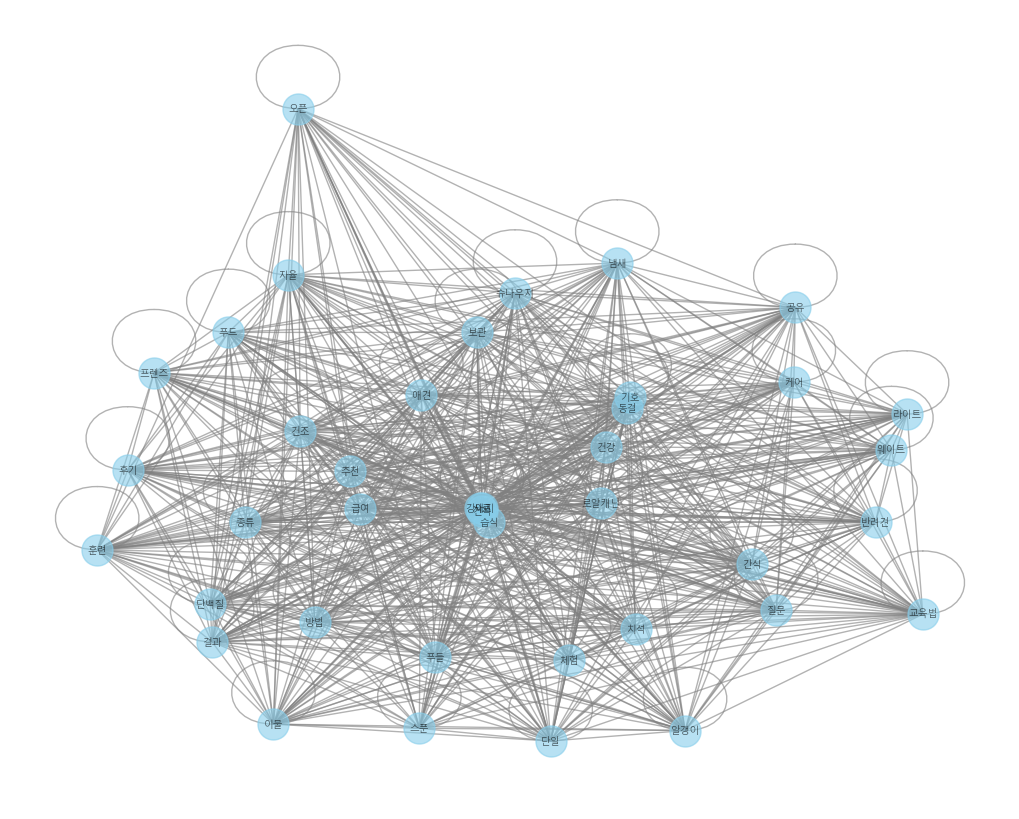

In [150]:
FONT_NAME= font_manager.FontProperties(fname=FONT_PATH).get_name()
plt.rc('font', family=FONT_NAME)
plt.figure(figsize=(10, 8))

# 네트워크 그래프 객체 생성
nx_graph = nx.Graph(edgelist)

# 노드에 단어 라벨을 매칭
label=dict(zip(nx_graph.nodes(), words_name))


# 네트워크 그래프 시각화
nx.draw(nx_graph, 
        labels=label,  # 노드에 라벨 추가
        with_labels=True,  # 라벨 표시
        font_family=FONT_NAME,  # 한글 폰트 설정
        node_color='skyblue',  # 노드 색상 설정
        font_size=7,  # 폰트 크기 설정
        node_size=500,  # 노드 크기 설정
        alpha=0.6,  # 투명도 설정
        edge_color='grey'  # 엣지 색상 설정
       )

plt.show()

-------------------

### 99. Gephi 시각화 데이터 생성

##### ***Gephi는 네트워크 분석 및 시각화 프로그램으로 파이썬보다 강력한 네트워크 분석 기능을 제공*** 

In [151]:
# 노드파일 저장
node_df = pd.DataFrame(list(label.items()), columns=['ID', 'Label'])
node_df.to_csv('node_df.csv',index=False, encoding='utf-8-sig')

# 엣지 파일 저장
edges=[]

for i in range(edgelist.shape[0]):
    for j in range(i+1, edgelist.shape[1]):  # 상삼각 행렬만 순회
        if edgelist[i, j] > 0:  # 가중치가 0보다 큰 경우만 엣지로 추가
            edges.append([i, j, edgelist[i, j]])
            
edge_df = pd.DataFrame(edges, columns=["Source", "Target", "Weight"])
edge_df.to_csv("edge_df.csv", index=False, encoding='utf-8-sig')